In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans 
from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from fcmeans import FCM
import random
import operator
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.shape

(800, 22)

In [4]:
df.head()

,Id,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,0,1,18,4,2,1049,1,2,4,2,...,2,21,3,1,1,3,2,1,2,1
1,1,1,9,4,0,2799,1,3,2,3,...,1,36,3,1,2,3,1,1,2,1
2,2,2,12,2,9,841,2,4,2,2,...,1,23,3,1,1,2,2,1,2,1
3,3,1,12,4,0,2122,1,3,3,3,...,1,39,3,1,2,2,1,1,1,1
4,5,1,10,4,0,2241,1,2,1,3,...,1,48,3,1,2,2,1,1,1,1


In [5]:
X = df.drop(['Id','kredit', 'gastarb', 'telef', 'laufkont', 'pers'], axis=1)

In [6]:
X.head()

,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf
0,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3
1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3
2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2
3,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2
4,10,4,0,2241,1,2,1,3,1,3,1,48,3,1,2,2


In [7]:
X.shape

(800, 16)

In [8]:
X.isnull().sum()

laufzeit    0
moral       0
verw        0
hoehe       0
sparkont    0
beszeit     0
rate        0
famges      0
buerge      0
wohnzeit    0
verm        0
alter       0
weitkred    0
wohn        0
bishkred    0
beruf       0
dtype: int64

In [9]:
scale = StandardScaler()
X_scaled = X # pd.DataFrame(scale.fit_transform(X.values), columns=X.columns)
X_scaled 

,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf
0,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3
1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3
2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2
3,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2
4,10,4,0,2241,1,2,1,3,1,3,1,48,3,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,18,4,0,3966,1,5,1,2,1,4,1,33,1,1,3,3
796,12,0,3,6199,1,3,4,3,1,2,2,28,3,1,2,3
797,21,4,0,12680,5,5,4,3,1,4,4,30,3,3,1,4
798,12,2,3,6468,5,1,2,3,1,1,4,52,3,2,1,4


In [10]:
X_scaled.shape

(800, 16)

In [11]:
k = 3 # number of clusters

In [12]:
m = 2 # m parameter

In [13]:
MAX_ITERS = 12  # number of iterations

In [14]:
n = X_scaled.shape[0]
n 

800

In [15]:
d = X_scaled.shape[1] #dimension of cluster
d

16

In [16]:
def initializeMembershipMatrix():
    membership_mat = list()
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

In [17]:
def calculateClusterCenter(membership_mat):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = list()
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [e ** m for e in x]
        denominator = sum(xraised)
        temp_num = list()
        for i in range(n):
            data_point = list(X_scaled.iloc[i])
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [18]:
def updateMembershipValue(membership_mat, cluster_centers):
    p = float(2/(m-1))
    for i in range(n):
        x = list(X_scaled.iloc[i])
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat

In [19]:
def fuzzyCMeansClustering():
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()

    for i in range(MAX_ITERS):
        cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        
    return membership_mat, cluster_centers

In [20]:
final_weights,Centers = fuzzyCMeansClustering()

In [21]:
final_weights = np.asarray(final_weights).round(2)
final_weights

array([[0.98, 0.  , 0.02],
       [0.45, 0.02, 0.53],
       [0.96, 0.01, 0.04],
       ...,
       [0.07, 0.82, 0.11],
       [0.13, 0.35, 0.52],
       [0.13, 0.31, 0.56]])

In [22]:
final_weights.shape

(800, 3)

In [23]:
Centers = np.asarray(Centers)
Centers

array([[1.48029934e+01, 2.62163089e+00, 2.81427599e+00, 1.48600570e+03,
        2.06424972e+00, 3.40695472e+00, 3.24475895e+00, 2.70430648e+00,
        1.15026876e+00, 2.78222580e+00, 2.11303979e+00, 3.57718012e+01,
        2.68062803e+00, 1.90252807e+00, 1.43836891e+00, 2.77945711e+00],
       [3.65506656e+01, 2.41738316e+00, 2.77385913e+00, 9.47164818e+03,
        2.63139346e+00, 3.25928302e+00, 2.28484685e+00, 2.67900287e+00,
        1.10772817e+00, 2.78437049e+00, 3.03672240e+00, 3.63981024e+01,
        2.59707085e+00, 2.13781382e+00, 1.35547565e+00, 3.26827239e+00],
       [2.47210115e+01, 2.56161694e+00, 2.72901365e+00, 4.01754748e+03,
        2.09774890e+00, 3.39681241e+00, 2.64586090e+00, 2.65013510e+00,
        1.15296495e+00, 2.86909090e+00, 2.50573960e+00, 3.45469098e+01,
        2.71001794e+00, 1.93922456e+00, 1.41475286e+00, 2.94804385e+00]])

In [24]:
Centers.shape

(3, 16)

In [25]:
def getAlphaCut(final_weights, threshold):
    crisp = np.zeros((n,k))
    for i in range(n):
        cluster = []
        for j in range(k): 
            #print(final_weights[i,j])
            if final_weights[i,j] > threshold:
                cluster.append(j+1)
                #print(j+1)
            else :
                cluster.append(0)
                #print(0)
        
        #print(cluster)
        crisp[i] = cluster
        
    return crisp

In [26]:
alpha = getAlphaCut(final_weights, threshold=0.33)
alpha.tolist()

[[1.0, 0.0, 0.0],
 [1.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [0.0, 2.0, 0.0],
 [1.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [0.0, 2.0, 0.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 3.0],
 [0.0, 0.0, 3.0],
 [0.0, 2.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0

# EDA

In [27]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [28]:
X_train.shape

(800, 22)

In [29]:
X_train.head()

,Id,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,0,1,18,4,2,1049,1,2,4,2,...,2,21,3,1,1,3,2,1,2,1
1,1,1,9,4,0,2799,1,3,2,3,...,1,36,3,1,2,3,1,1,2,1
2,2,2,12,2,9,841,2,4,2,2,...,1,23,3,1,1,2,2,1,2,1
3,3,1,12,4,0,2122,1,3,3,3,...,1,39,3,1,2,2,1,1,1,1
4,5,1,10,4,0,2241,1,2,1,3,...,1,48,3,1,2,2,1,1,1,1


In [30]:
X_train.describe()

,Id,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,478.101250,2.648750,20.496250,2.582500,2.785000,3210.290000,2.143750,3.39500,2.952500,2.687500,...,2.353750,35.542500,2.673750,1.941250,1.420000,2.901250,1.845000,1.398750,1.957500,0.750000
std,278.883661,1.250931,12.006881,1.099866,2.680533,2792.840814,1.589416,1.22407,1.134395,0.696743,...,1.057122,11.175724,0.709182,0.527396,0.586541,0.661094,0.362131,0.489947,0.201853,0.433284
min,0.000000,1.000000,4.000000,0.000000,0.000000,250.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,238.750000,1.750000,12.000000,2.000000,1.000000,1364.000000,1.000000,3.00000,2.000000,2.000000,...,1.000000,27.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.750000
50%,472.000000,2.000000,18.000000,2.000000,2.000000,2264.000000,1.000000,3.00000,3.000000,3.000000,...,2.000000,33.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,707.250000,4.000000,24.000000,4.000000,3.000000,3907.250000,3.000000,5.00000,4.000000,3.000000,...,3.000000,42.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,999.000000,4.000000,72.000000,4.000000,10.000000,18424.000000,5.000000,5.00000,4.000000,4.000000,...,4.000000,75.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        800 non-null    int64
 1   laufkont  800 non-null    int64
 2   laufzeit  800 non-null    int64
 3   moral     800 non-null    int64
 4   verw      800 non-null    int64
 5   hoehe     800 non-null    int64
 6   sparkont  800 non-null    int64
 7   beszeit   800 non-null    int64
 8   rate      800 non-null    int64
 9   famges    800 non-null    int64
 10  buerge    800 non-null    int64
 11  wohnzeit  800 non-null    int64
 12  verm      800 non-null    int64
 13  alter     800 non-null    int64
 14  weitkred  800 non-null    int64
 15  wohn      800 non-null    int64
 16  bishkred  800 non-null    int64
 17  beruf     800 non-null    int64
 18  pers      800 non-null    int64
 19  telef     800 non-null    int64
 20  gastarb   800 non-null    int64
 21  kredit    800 non-null    int64
dtypes:

In [32]:
X_train.isnull().sum()

Id          0
laufkont    0
laufzeit    0
moral       0
verw        0
hoehe       0
sparkont    0
beszeit     0
rate        0
famges      0
buerge      0
wohnzeit    0
verm        0
alter       0
weitkred    0
wohn        0
bishkred    0
beruf       0
pers        0
telef       0
gastarb     0
kredit      0
dtype: int64

In [33]:
X_test.shape

(200, 21)

In [34]:
X_test.head()

,Id,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb
0,4,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,2,1,1
1,14,1,18,2,3,1936,5,4,2,4,...,4,3,23,3,1,2,2,2,1,2
2,18,2,36,4,3,2337,1,5,4,3,...,4,1,36,3,2,1,3,2,1,2
3,20,1,6,4,0,3676,1,3,1,3,...,3,1,37,3,1,3,3,1,1,2
4,22,2,36,2,5,2384,1,2,4,3,...,1,4,33,3,1,1,2,2,1,2


In [35]:
X_test.describe()

,Id,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,585.095000,2.290000,22.530000,2.395000,3.000000,3515.080000,1.950,3.340000,3.055000,2.660000,...,2.925000,2.375000,35.540000,2.68000,1.875000,1.355000,2.915000,1.845000,1.425000,1.985000
std,311.895834,1.246462,12.158877,1.001995,2.987411,2933.884667,1.536,1.144969,1.052384,0.753151,...,1.116066,1.024511,12.063834,0.69282,0.539286,0.538913,0.624278,0.362813,0.495584,0.121857
min,4.000000,1.000000,6.000000,0.000000,0.000000,338.000000,1.000,1.000000,1.000000,1.000000,...,1.000000,1.000000,20.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,303.000000,1.000000,12.000000,2.000000,1.000000,1373.500000,1.000,3.000000,2.000000,2.000000,...,2.000000,1.000000,26.000000,3.00000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000
50%,661.000000,2.000000,19.000000,2.000000,2.000000,2443.000000,1.000,3.000000,3.000000,3.000000,...,3.000000,2.000000,33.000000,3.00000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000
75%,857.500000,4.000000,30.000000,3.000000,3.000000,4572.500000,2.250,4.000000,4.000000,3.000000,...,4.000000,3.000000,41.250000,3.00000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000
max,996.000000,4.000000,60.000000,4.000000,10.000000,14896.000000,5.000,5.000000,4.000000,4.000000,...,4.000000,4.000000,75.000000,3.00000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        200 non-null    int64
 1   laufkont  200 non-null    int64
 2   laufzeit  200 non-null    int64
 3   moral     200 non-null    int64
 4   verw      200 non-null    int64
 5   hoehe     200 non-null    int64
 6   sparkont  200 non-null    int64
 7   beszeit   200 non-null    int64
 8   rate      200 non-null    int64
 9   famges    200 non-null    int64
 10  buerge    200 non-null    int64
 11  wohnzeit  200 non-null    int64
 12  verm      200 non-null    int64
 13  alter     200 non-null    int64
 14  weitkred  200 non-null    int64
 15  wohn      200 non-null    int64
 16  bishkred  200 non-null    int64
 17  beruf     200 non-null    int64
 18  pers      200 non-null    int64
 19  telef     200 non-null    int64
 20  gastarb   200 non-null    int64
dtypes: int64(21)
memory usage: 32.9 KB


In [37]:
X_test.isnull().sum()

Id          0
laufkont    0
laufzeit    0
moral       0
verw        0
hoehe       0
sparkont    0
beszeit     0
rate        0
famges      0
buerge      0
wohnzeit    0
verm        0
alter       0
weitkred    0
wohn        0
bishkred    0
beruf       0
pers        0
telef       0
gastarb     0
dtype: int64

In [38]:
Y_train = X_train['kredit']

In [39]:
corr_matrix = X_train.corr().round(2)
corr_matrix

,Id,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
Id,1.00,-0.32,0.17,-0.20,0.05,0.17,-0.13,-0.08,0.09,0.02,...,0.13,-0.08,-0.14,0.07,0.02,0.06,0.00,-0.03,0.09,-0.68
laufkont,-0.32,1.00,-0.06,0.20,0.05,-0.05,0.19,0.12,0.01,0.04,...,-0.03,0.06,0.08,0.01,0.08,0.05,0.02,0.07,0.03,0.34
laufzeit,0.17,-0.06,1.00,-0.10,0.12,0.63,0.06,0.04,0.07,0.02,...,0.31,-0.02,-0.05,0.18,-0.05,0.21,0.03,0.17,0.14,-0.19
moral,-0.20,0.20,-0.10,1.00,-0.08,-0.06,0.04,0.13,0.03,0.03,...,-0.04,0.18,0.19,0.05,0.45,0.01,-0.02,0.05,-0.00,0.23
verw,0.05,0.05,0.12,-0.08,1.00,0.06,-0.02,0.04,0.04,-0.02,...,0.01,0.02,-0.10,0.04,0.05,-0.01,0.04,0.07,0.12,-0.02
hoehe,0.17,-0.05,0.63,-0.06,0.06,1.00,0.07,-0.04,-0.28,-0.01,...,0.32,0.02,-0.04,0.15,-0.04,0.27,-0.03,0.29,0.03,-0.14
sparkont,-0.13,0.19,0.06,0.04,-0.02,0.07,1.00,0.14,0.02,0.01,...,0.02,0.07,0.02,-0.01,-0.05,-0.00,-0.02,0.09,-0.02,0.16
beszeit,-0.08,0.12,0.04,0.13,0.04,-0.04,0.14,1.00,0.14,0.09,...,0.09,0.24,-0.01,0.10,0.11,0.11,-0.13,0.09,0.04,0.11
rate,0.09,0.01,0.07,0.03,0.04,-0.28,0.02,0.14,1.00,0.12,...,0.06,0.07,-0.00,0.10,0.03,0.11,0.10,0.02,0.11,-0.08
famges,0.02,0.04,0.02,0.03,-0.02,-0.01,0.01,0.09,0.12,1.00,...,-0.00,0.01,-0.04,0.10,0.05,0.01,-0.14,0.02,-0.09,0.04


In [40]:
#X_train.drop(['kredit'], axis=1,inplace=True)
X_train.drop(['Id','telef','kredit'], axis=1,inplace=True) 

In [41]:
X_test.drop(['Id','telef'], axis=1,inplace=True)

In [42]:
X_train.shape

(800, 19)

In [43]:
scale = StandardScaler()
X_scaled_train = scale.fit_transform(X_train)

In [44]:
X_scaled_train.shape

(800, 19)

In [45]:
type(X_scaled_train)

numpy.ndarray

In [46]:
Y_train.describe()

count    800.000000
mean       0.750000
std        0.433284
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: kredit, dtype: float64

In [47]:
Y_train.shape

(800,)

In [48]:
Y_train.value_counts().sort_index()

0    200
1    600
Name: kredit, dtype: int64

<AxesSubplot:>

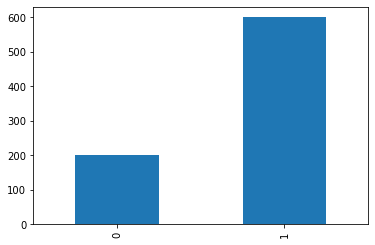

In [49]:
Y_train.value_counts().sort_index().plot.bar()

## K means Algorithms : 

Text(0.5, 1.0, 'Elbow curve')

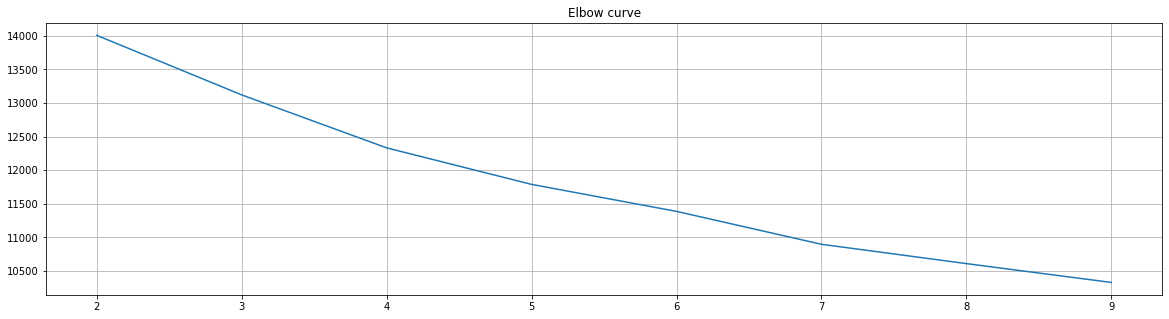

In [50]:
for_clustering = X_scaled_train
distorsions = []
for ik in range(2, 10):
    kmeans = KMeans(n_clusters=ik)
    kmeans.fit(for_clustering)
    distorsions.append(kmeans.inertia_) # adding the sum of squared errors

# plotting the chart
fig = plt.figure(figsize=(20, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [51]:
modelKMean = KMeans(n_clusters=2, max_iter=1000)
modelKMean.fit(X_scaled_train)

KMeans(max_iter=1000, n_clusters=2)

In [52]:
modelKMean.n_features_in_

19

In [53]:
modelKMean.cluster_centers_

array([[-0.10221074, -0.43376089, -0.06401027, -0.07878306, -0.35809283,
        -0.13775   , -0.28500039, -0.15866217, -0.10917734,  0.14433132,
        -0.23832164, -0.50409593, -0.23475977,  0.08967595, -0.33249275,
        -0.08759613, -0.35172206,  0.10500612, -0.15043943],
       [ 0.13343362,  0.56626421,  0.08356383,  0.10284936,  0.46748142,
         0.17982924,  0.37206102,  0.20712958,  0.14252834, -0.188421  ,
         0.31112307,  0.65808488,  0.30647313, -0.11706976,  0.43406115,
         0.1143546 ,  0.45916453, -0.13708292,  0.19639499]])

In [54]:
labels = modelKMean.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,

## Model Evaluation

### Accuracy 

In [55]:
# accuracy on training data
y_train_predict = modelKMean.predict(X_train.values)
training_data_accuracy = accuracy_score(y_train_predict,Y_train)
print('Accuracy on Training data : ', round(training_data_accuracy*100, 2), '%')

Accuracy on Training data :  75.0 %


### Precision

Precision is the ratio of number of True Positive to the total number of Predicted Positive. It measures, out of the total predicted positive, how many are actually positive.

In [56]:
# precision for training data predictions
precision_train = precision_score(Y_train, y_train_predict, pos_label='positive', average='micro')
print('Training data Precision =', precision_train)

Training data Precision = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


### Recall

Recall is the ratio of number of True Positive to the total number of Actual Positive. It measures, out of the total actual positive, how many are predicted as True Positive.

In [57]:
# recall for training data predictions
recall_train = recall_score(Y_train, y_train_predict, pos_label='positive', average='micro')
print('Training data Recall =', recall_train)

C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Training data Recall = 0.75


### F1 Score

F1 Score is an important evaluation metric for binary classification that combines Precision & Recall. F1 Score is the harmonic mean of Precision & Recall.

In [58]:
# F1 score for training data predictions
f1_score_train = f1_score(Y_train, y_train_predict, pos_label='positive', average='micro')
print('Training data F1 Score =', f1_score_train)

Training data F1 Score = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


# Fuzzy C mean 

In [59]:
initial_centers = kmeans_plusplus_initializer(X_scaled_train,2,kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()

In [60]:
modelCMean = fcm(X_scaled_train,initial_centers)
modelCMean.process()
member = modelCMean.get_membership()
member

[[0.5001949515119158, 0.49980504848808416],
 [0.5001982476507312, 0.4998017523492688],
 [0.5002159082376654, 0.4997840917623346],
 [0.5001205862784199, 0.4998794137215802],
 [0.5001050084770542, 0.49989499152294586],
 [0.500097567588844, 0.499902432411156],
 [0.5000969657238513, 0.49990303427614863],
 [0.5001156821795597, 0.49988431782044035],
 [0.5000236822327606, 0.49997631776723944],
 [0.5001716407147717, 0.4998283592852283],
 [0.49992740260297985, 0.5000725973970201],
 [0.5000677550008924, 0.49993224499910754],
 [0.49976033179978774, 0.5002396682002123],
 [0.5001480021862045, 0.49985199781379563],
 [0.5001475093386094, 0.4998524906613906],
 [0.5001366902956788, 0.49986330970432113],
 [0.5001031610542559, 0.49989683894574394],
 [0.5000882238639863, 0.4999117761360137],
 [0.5002905985909206, 0.4997094014090793],
 [0.5001086166122491, 0.4998913833877509],
 [0.4999911601572463, 0.5000088398427537],
 [0.5001652099944577, 0.4998347900055423],
 [0.4998871441551909, 0.5001128558448091],
 [

In [61]:
FCMean_clusters = modelCMean.get_clusters()
FCMean_clusters

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  21,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  38,
  39,
  40,
  42,
  44,
  45,
  46,
  49,
  53,
  54,
  56,
  60,
  62,
  65,
  66,
  68,
  69,
  70,
  71,
  72,
  75,
  76,
  77,
  78,
  80,
  81,
  83,
  84,
  86,
  88,
  89,
  90,
  94,
  95,
  96,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  108,
  111,
  114,
  115,
  116,
  117,
  118,
  121,
  123,
  124,
  125,
  126,
  128,
  129,
  132,
  133,
  135,
  137,
  139,
  140,
  141,
  143,
  144,
  147,
  155,
  156,
  159,
  164,
  166,
  168,
  169,
  172,
  173,
  174,
  175,
  176,
  178,
  181,
  184,
  186,
  187,
  189,
  193,
  194,
  195,
  197,
  198,
  199,
  200,
  201,
  202,
  204,
  205,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  216,
  217,
  220,
  223,
  225,
  227,
  228,
  229,
  230,
  231,
  233,
  234,
  236,
  237,
  238,
  240,
  242,
  243,
  244,
  245,
  249

In [62]:
FCMean_centers = modelCMean.get_centers()
FCMean_centers

[[4.454444144004051e-05,
  -0.00021480279005352623,
  6.507961747145274e-05,
  -1.8370017467898346e-05,
  -0.00019835738241531144,
  -3.490583523492901e-05,
  -5.714091929212679e-05,
  6.341749253374668e-06,
  -2.782356349413695e-05,
  1.519839098950239e-05,
  -5.127840395509234e-05,
  -0.00022296372581599323,
  -4.389748260825607e-05,
  6.735346468440161e-05,
  -0.000125169589816697,
  3.8111953151026566e-05,
  -0.00013023098817979855,
  3.616736198581016e-05,
  -1.8626491015299947e-05],
 [-4.454763848533552e-05,
  0.00021481820688655043,
  -6.508428836784274e-05,
  1.837133592122883e-05,
  0.00019837161892766704,
  3.490834049787272e-05,
  5.71450204120267e-05,
  -6.342204413789306e-06,
  2.782556044783829e-05,
  -1.5199481809183302e-05,
  5.128208431006725e-05,
  0.00022297972837605405,
  4.390063322038329e-05,
  -6.73582987796841e-05,
  0.00012517857349286313,
  -3.811468852319526e-05,
  0.00013024033512216147,
  -3.6169957790823824e-05,
  1.862782787637221e-05]]

## Model Evaluation

### Accuracy 

In [63]:
modelFCM = FCM(n_clusters=2)
modelFCM.fit(X_scaled_train)

In [64]:
# accuracy on training data
y_train_predict_cmean = modelFCM.predict(X_train.values)
training_data_accuracy = accuracy_score(y_train_predict_cmean,Y_train)
print('Accuracy on Training data : ', round(training_data_accuracy*100, 2), '%')

Accuracy on Training data :  75.0 %


### Precision

Precision is the ratio of number of True Positive to the total number of Predicted Positive. It measures, out of the total predicted positive, how many are actually positive.

In [65]:
# precision for training data predictions
precision_train_cmean = precision_score(Y_train, y_train_predict_cmean, pos_label='positive', average='micro')
print('Training data Precision =', precision_train_cmean)

Training data Precision = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


### Recall

Recall is the ratio of number of True Positive to the total number of Actual Positive. It measures, out of the total actual positive, how many are predicted as True Positive.

In [66]:
# recall for training data predictions
recall_train_cmean = recall_score(Y_train, y_train_predict_cmean, pos_label='positive', average='micro')
print('Training data Recall =', recall_train_cmean)

Training data Recall = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


### F1 Score

F1 Score is an important evaluation metric for binary classification that combines Precision & Recall. F1 Score is the harmonic mean of Precision & Recall.

In [67]:
# F1 score for training data predictions
f1_score_train_cmean = f1_score(Y_train, y_train_predict_cmean, pos_label='positive', average='micro')
print('Training data F1 Score =', f1_score_train_cmean)

Training data F1 Score = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


# SVM

In [68]:
model_svm = SVC()
model_svm.fit(X_scaled_train,Y_train)

SVC()

In [69]:
model_svm.classes_

array([0, 1], dtype=int64)

## Model Evaluation

### Accuracy 

In [70]:
# accuracy on training data
y_train_predict_svm = model_svm.predict(X_train.values)
training_data_accuracy = accuracy_score(y_train_predict_svm,Y_train)
print('Accuracy on Training data : ', round(training_data_accuracy*100, 2), '%')

Accuracy on Training data :  75.0 %


### Precision

Precision is the ratio of number of True Positive to the total number of Predicted Positive. It measures, out of the total predicted positive, how many are actually positive.

In [71]:
# precision for training data predictions
precision_train_svm = precision_score(Y_train, y_train_predict_svm, pos_label='positive', average='micro')
print('Training data Precision =', precision_train_svm)

Training data Precision = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


### Recall

Recall is the ratio of number of True Positive to the total number of Actual Positive. It measures, out of the total actual positive, how many are predicted as True Positive.

In [72]:
# recall for training data predictions
recall_train_svm = recall_score(Y_train, y_train_predict_svm, pos_label='positive', average='micro')
print('Training data Recall =', recall_train_svm)

Training data Recall = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


### F1 Score

F1 Score is an important evaluation metric for binary classification that combines Precision & Recall. F1 Score is the harmonic mean of Precision & Recall.

In [73]:
# F1 score for training data predictions
f1_score_train_svm = f1_score(Y_train, y_train_predict_svm, pos_label='positive', average='micro')
print('Training data F1 Score =', f1_score_train_svm)

Training data F1 Score = 0.75


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


# Logistic Regression

In [72]:
def sigmoid(z):
    g = 1 / (1+np.exp(-z))
    
    return g

In [73]:
def compute_cost(X_, y_, w, b):
    
    m_, n_ = X.shape
    loss = 0 
    
    for i in range(m_):
        fxi = sigmoid(np.dot(w.T,X_[i])+b) 
        loss += (-y_[i] * np.log(fxi) - (1-y_[i]) * np.log(1-fxi))
    total_cost = loss / m_
    
    return total_cost

In [74]:
def compute_gradient(X_, y_, w, b): 
    
    m_, n_ = X_.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m_):
        z_wb = 0
        for j in range(n_): 
            z_wb += w[j] * X_[i][j]
        z_wb += b
        f_wb = sigmoid(z_wb)
        
        dj_db_i = f_wb - y_[i]
        dj_db += dj_db_i
        
        for j in range(n_):
            dj_dw[j] += (f_wb - y_[i]) * X_[i][j]
            
            
    dj_dw /= m_ 
    dj_db /= m_
   
    return dj_db, dj_dw

In [75]:
def gradient_descent(X_, y_, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    
    # number of training examples
    m_ = len(X_)
    
    # An array to store cost J and w's at each iteration primarily 
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X_, y_, w_in, b_in)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X_, y_, w_in, b_in)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
            print(f"w = {w_in}, b = {b_in}")
    
    print(f"Finished !!")
        
    return w_in, b_in

In [76]:
np.random.seed(1)
initial_w = 0.001 * (np.random.rand(X_scaled_train.shape[1]).reshape(-1,1) - 0.5)
initial_b = -8

print(initial_w.shape)
# Some gradient descent settings
iterations = 100
alpha = 0.0001

w_final,b_final = gradient_descent(X_scaled_train,Y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations)

(19, 1)
Iteration    0: Cost     6.00   
w = [[-3.56630692e-05]
 [ 2.37071882e-04]
 [-4.48751000e-04]
 [-1.77064255e-04]
 [-3.41947595e-04]
 [-3.83452230e-04]
 [-2.67353592e-04]
 [-1.06961072e-04]
 [-6.06263667e-05]
 [ 4.43143261e-05]
 [-3.51175278e-05]
 [ 2.17121053e-04]
 [-2.72593358e-04]
 [ 4.42526903e-04]
 [-4.37315669e-04]
 [ 1.81296155e-04]
 [-3.54664253e-05]
 [ 1.21911524e-04]
 [-2.88520133e-04]], b = [-7.99992503]
Iteration   10: Cost     6.00   
w = [[ 4.37485654e-04]
 [ 4.04545541e-04]
 [ 6.25946371e-05]
 [ 2.89672004e-05]
 [-2.28982609e-04]
 [-1.41360763e-04]
 [ 1.96507792e-04]
 [ 3.67820306e-04]
 [ 3.65434692e-04]
 [ 9.92901842e-05]
 [ 4.21761463e-04]
 [ 5.36136137e-04]
 [-4.30497204e-05]
 [ 1.08662077e-03]
 [-8.43487441e-05]
 [ 2.89582463e-04]
 [ 4.36820694e-04]
 [ 7.54127670e-04]
 [ 4.22408244e-04]], b = [-7.99917537]
Iteration   20: Cost     5.99   
w = [[ 0.00091063]
 [ 0.00057202]
 [ 0.00057394]
 [ 0.000235  ]
 [-0.00011602]
 [ 0.00010073]
 [ 0.00066037]
 [ 0.0008426 ]

In [77]:
def predict(X_p, w, b): 
    
    m_, n_ = X_p.shape   
    p = np.zeros(m_)
     
    z_wb = 0
    z_wb = np.dot(X_p,w)
        
    # Add bias term 
    z_wb += b
        
    # Calculate the prediction for this example
    f_wb = sigmoid(z_wb)
    
    # Apply the threshold
    
    pred_class = []
    # if y_hat >= 0.5 --> round up to 1
    # if y_hat < 0.5 --> round up to 0
    pred_class = [1 if i > 0.5 else 0 for i in f_wb]
    
    return np.asarray(pred_class)

## Model Evaluation

### Accuracy 

In [78]:
# accuracy on training data
y_train_predict_LR = predict(X_p=X_scaled_train, w=w_final, b=b_final)
training_data_accuracy = accuracy_score(y_train_predict_LR,Y_train)
print('Accuracy on Training data : ', round(training_data_accuracy*100, 2), '%')

Accuracy on Training data :  25.0 %


### Precision

Precision is the ratio of number of True Positive to the total number of Predicted Positive. It measures, out of the total predicted positive, how many are actually positive.

In [79]:
# precision for training data predictions
precision_train_LR = precision_score(Y_train, y_train_predict_LR, pos_label='positive', average='micro')
print('Training data Precision =', precision_train_LR)

Training data Precision = 0.25


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


### Recall

Recall is the ratio of number of True Positive to the total number of Actual Positive. It measures, out of the total actual positive, how many are predicted as True Positive.

In [80]:
# recall for training data predictions
recall_train_LR = recall_score(Y_train, y_train_predict_LR, pos_label='positive', average='micro')
print('Training data Recall =', recall_train_LR)

C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Training data Recall = 0.25


### F1 Score

F1 Score is an important evaluation metric for binary classification that combines Precision & Recall. F1 Score is the harmonic mean of Precision & Recall.

In [81]:
# F1 score for training data predictions
f1_score_train_LR = f1_score(Y_train, y_train_predict_LR, pos_label='positive', average='micro')
print('Training data F1 Score =', f1_score_train_LR)

Training data F1 Score = 0.25


C:\Users\Mohanad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [82]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_scaled_train, Y_train)


LogisticRegression(random_state=0)

In [83]:
y_pred = classifier.predict(X_train)
training_data_accuracy_LR = accuracy_score(y_pred,Y_train)
print('Accuracy on Training data : ', round(training_data_accuracy_LR*100, 2), '%')

Accuracy on Training data :  25.0 %


In [84]:
y_test_predict_LR = predict(X_p=X_test, w=w_final, b=b_final)
y_test_predict_LR

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0])

In [85]:
y_test_predict_class = classifier.predict(X_test)
y_test_predict_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)